### Introduction

**Goal**: Build an automatic system that counts the total value of Euros and Swiss Francs on an iage.

**Dataset**: Train and test datasets are provided. Images contain coins that can be: Head/Tail, CHF/EUR/OOD

**Kaggle team name**: ba3ba3

**Group ID:** 60

**Author 1 (sciper):** Ali Raed Ben Mustapha (300392)  
**Author 2 (sciper):** Khalil Acheche (300350)   
**Author 3 (sciper):** Leila Aissa (325708)   

## 1-Annotation

We annotate the training set using [Roboflow](https://app.roboflow.com/) as it is an intuitive tool that speeds up the annotation process. 

**Classes**: Apart from the OOD, for each coin, we have 2 classes to specify whether it is head or tail. For instance, we have 5chf_head and 5chaf_tail ... This choice is made after careful data inspection. Indeed training a model to distinguish not only coins but also head and tail sides yields a more robust model. Since for a single coin, the 2 sides may have completely different designs, treating them as different classes would allow the model to learn better features. Obviously, after prediction, we will aggregate the 2 sides classes into a single class.

## 2-Coin Extraction

Please find the implementation and training script and inference in the notebook: `train_faster_RCNN.ipynb`

We use the model [Faster R-CNN](https://arxiv.org/pdf/1506.01497) for object detection. It is renowned for its high accuracy in detecting objects, even in complex images. In particular, we use Faster RCNN with resnet50 as a backbone. ResNet-50 backbone is loaded with weights pre-trained on the ImageNet dataset which is a large visual database often used for pre-training models on image recognition tasks. We ensure that Faster R-CNN model itself is not loaded with pre-trained weights except for the backbone to satisfy the constraints of the project.

Using Faster RCNN yields an F1 score of ~89% on Kaggle. When inspecting the training and validation sets, we observe that all coins were detected but not necessarily correctly classified. Thus, there are still opportunities for improvement. We decide to use Faster RCNN for coin detection and another model will then be used to classify the extracted coins.

To get an idea, below we provide some examples of the output (bounding boxes and predictions) of our model when we have the labels (train/val set)

In [1]:
import torch
import torchvision
from PIL import Image
from torchvision.ops import nms
import torchvision.transforms.functional as F

class CoinExtractor:
    def __init__(self, model_path):
        self.model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None, num_classes=25)
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        self.model.load_state_dict(torch.load(model_path,map_location=self.device))
        self.model = self.model.to(self.device)
        self.model.eval()
    def extract_bboxes(self,image,return_class=False):
        image = F.to_tensor(image).unsqueeze(0).to(self.device)
        with torch.no_grad():
            prediction = self.model(image).pop()

            scores = prediction['scores'].to('cpu').numpy()
            bboxs = prediction['boxes'].to('cpu').numpy()
            indices = nms(prediction['boxes'], prediction['scores'], iou_threshold=0.3).to('cpu').numpy()
            mask = [i in indices for i in range(len(scores))]
            mask = mask & (scores > 0.4)
            filtered_bboxs = bboxs[mask]
            if return_class:
                class_names = open('data/frcnn_class_names.txt').read().split('\n')
                classes = prediction['labels'].to('cpu').numpy()
                filtered_classes = classes[mask]
                filtered_class_names = [class_names[c] for c in filtered_classes]
                filtered_scores = scores[mask]
                return filtered_class_names,filtered_bboxs,filtered_scores

            return filtered_bboxs
    def extract_coins(self, image, bboxes, size=None):
        coins = []
        for bbox in bboxes:
            x1, y1, x2, y2 = bbox
            if size is None:
                coin = image.crop((x1, y1, x2, y2))
            else:
                center = ((x1 + x2) // 2, (y1 + y2) // 2)
                coin = image.crop((center[0] - size // 2, center[1] - size // 2, center[0] + size // 2, center[1] + size // 2))
            coins.append(coin)
        return coins
    def extract(self, image):
        bboxes = self.extract_bboxes(image)
        coins = self.extract_coins(image, bboxes, size=900)
        return coins

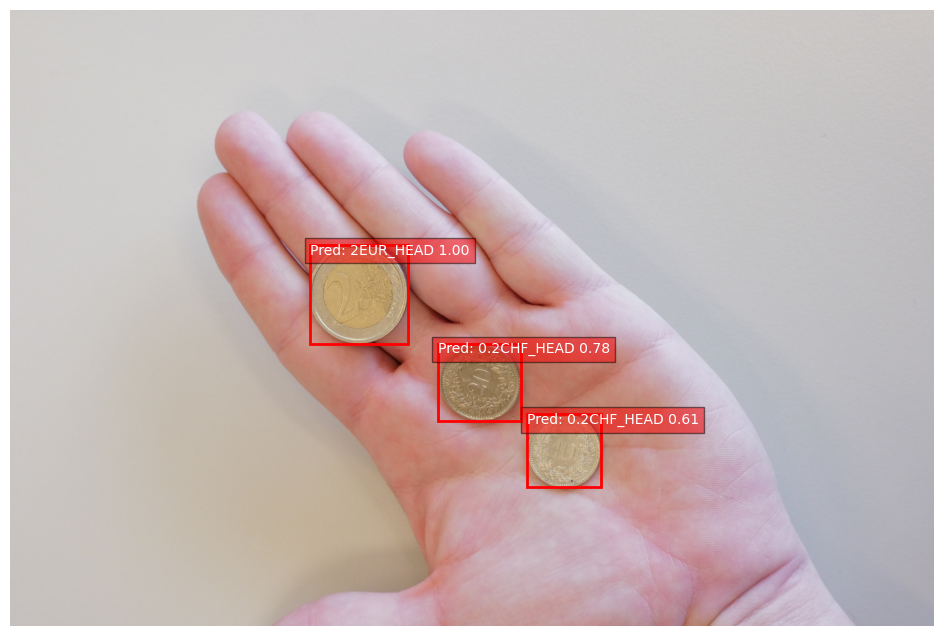

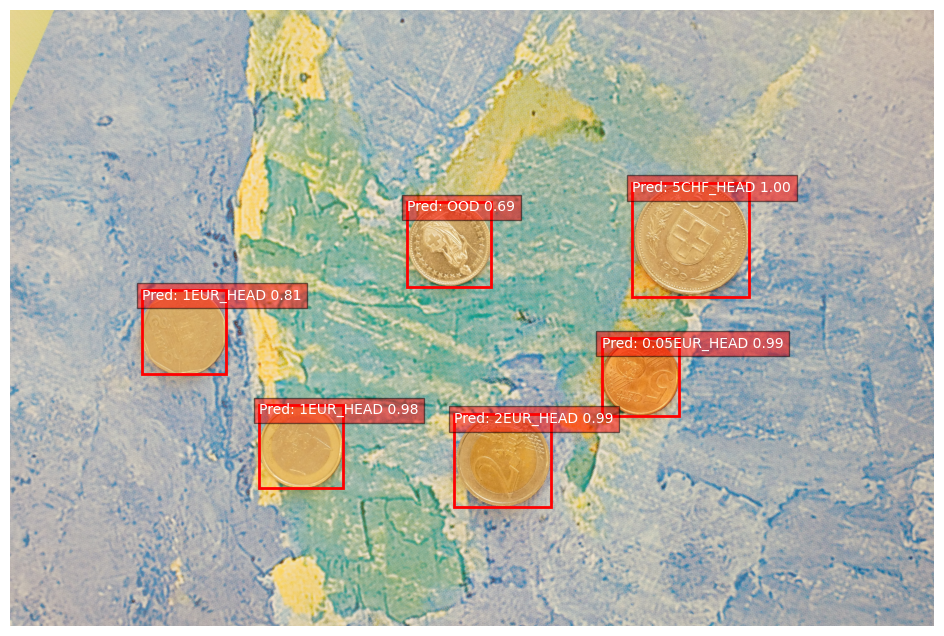

In [2]:
from utils import show_bbox

coin_extractor = CoinExtractor('models/fasterRCNN_coin_detector.pth')

image = Image.open('data/test/L0000000.jpg')
labels,bboxes,scores = coin_extractor.extract_bboxes(image,return_class=True)
show_bbox(image,labels,bboxes,scores)

image = Image.open('data/test/L0000056.jpg')
labels,bboxes,scores = coin_extractor.extract_bboxes(image,return_class=True)
show_bbox(image,labels,bboxes,scores)

We will use only the bounding boxes from faster RCNN predictions and use another more performant model for classification.

## 3- Data processing/augmentation

Please find the full code for data augmentation and processing in the notebook `preprocess_data.ipynb` file

### 3.1 Data Extraction

The first step is to extract the data from the file. The annotated images are COCO format. The data is in the form of a dictionary with the following keys:
- `info`: Information about the dataset
- `licenses`: License information
- `images`: Image information
- `annotations`: Annotation information
- `categories`: Category information

We are interested in the `images` and `annotations` keys. The `images` key contains information about the images, such as the image ID, file name, and image size. The `annotations` key contains information about the annotations, such as the annotation ID, image ID, category ID, and bounding box coordinates.

For each annotation, we will extract the coin patch from the image using the bounding box coordinates.

The coin patches are then saved as separate images in a new directory. With the images, we create a `labels.csv` file that contains the file name, category ID, and bounding box coordinates for each coin patch.

We have seen that the largest coin fits into an 860x860 pixel square. To allow for rotation augmentation and allow having a neutral background , we used a 1400x1400 pixel square to extract the coin patch. The final augmented coin patches are cropped around the center at 900x900 pixels to allow for some margin over the estimated 860x860px max coin size.


### 3.2 Data Formatting
We then save the images in a folder for each class, so that we can directly use the ImageFolder dataset from PyTorch to load the data


### 3.3 Data Augmentation
We have seen that the data is not balanced in the dataset. We decided to perform data augmentation both for the balancing of the dataset and to increase its size.

We use the following transformations:
* Random translation, to simulate the coin being off-center
* Random rotation, to train the model on different orientations of the coin
* Random brightness, to simulate different lighting conditions
* Random contrast, to simulate different lighting conditions
* Random blur, to simulate different focus conditions


## 4- Coin Classification

Please find the training script for our coin classification in : `trainFastViT.py`

We chose [FastViT](https://arxiv.org/pdf/2303.14189) for our coin classification model because it leverages the advanced capabilities of Vision Transformers, pretrained on the large-scale ImageNet-1k dataset, providing a strong foundation with generalized features. Despite its robust performance, FastViT remains efficient and lightweight, not exceeding 400 MB in size, making it ideal for deployment on resource-constrained devices. The architectural optimizations of FastViT offer an exceptional balance of speed and accuracy, crucial for capturing the intricate details in coin images while maintaining high throughput and responsiveness. Specifically, we selected FastViT-MA36, which demonstrated the best top-1 accuracy on ImageNet-1k among the FastViT models.

FastViT performed really well on the classification task, achieving an F1 score of ~95% on Kaggle.

Code for the coin classifier inference:

In [3]:
import timm
import torch
from matplotlib import pyplot as plt 
from PIL import Image
import os 

## This class is used to classify the coins using the model trained in the previous step
class CoinClassifier:
    def __init__(self, model_path,class_names_path):

        with open(class_names_path) as f:
            self.class_names = f.read().splitlines()
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        # initialize the model
        self.model = timm.create_model('fastvit_ma36.apple_in1k', pretrained=False, num_classes=len(self.class_names))
        # load the model
        self.model.load_state_dict(torch.load(model_path,map_location=self.device))
        self.model = self.model.to(self.device)
        # get the data configuration
        data_config = timm.data.resolve_model_data_config(self.model)
        # get the transforms needed for the model
        self.transforms = timm.data.create_transform(**data_config, is_training=False)
        self.model.eval()

    def classify(self, image):
        # apply transforms to the image before passing it to the model
        image = self.transforms(image).unsqueeze(0).to(self.device)
        with torch.no_grad():
            prediction = self.model(image)
            score,index = torch.topk(prediction.softmax(dim=1) * 100, k=1)
            score = score.squeeze().item()
            index = index.squeeze().item()
            prediction = self.class_names[index]
            return prediction, score

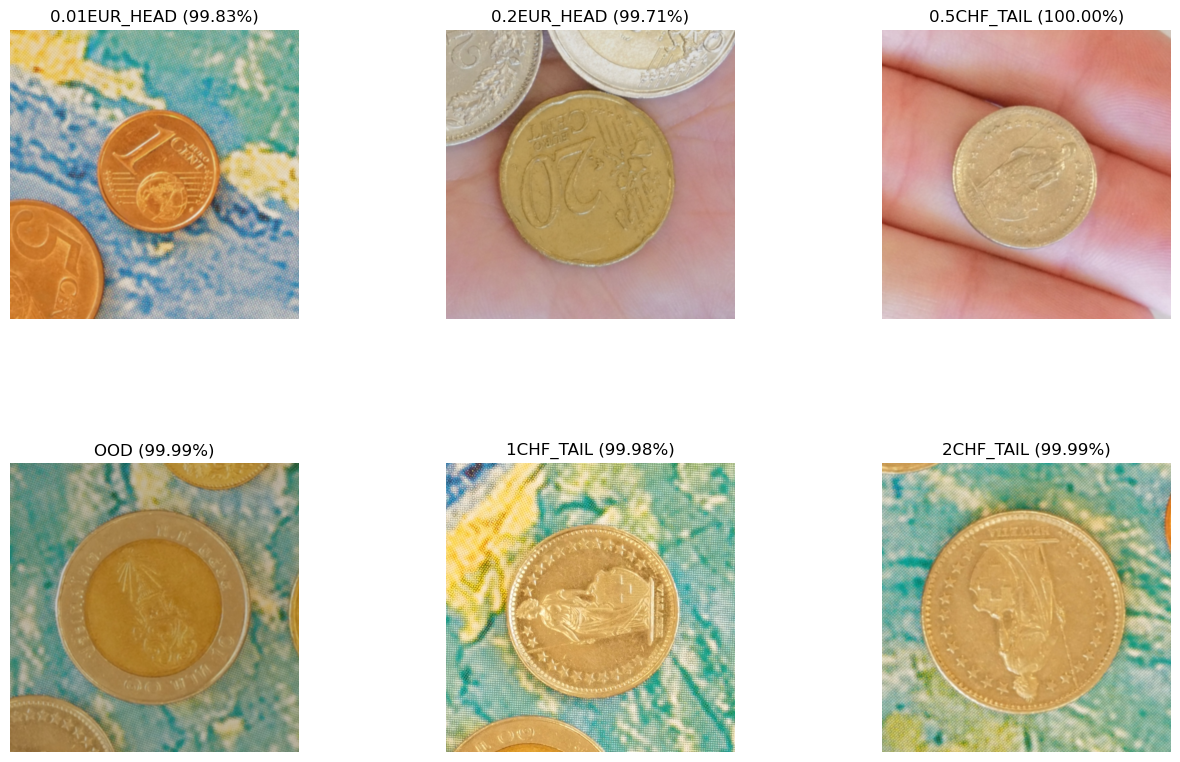

In [4]:
# inference
model_path = 'models/FastViT_coin_classifier.pth'
class_names_path = 'data/class_names.txt'
test_data_path = "notebook_examples/test_classifier_data/"
classifier = CoinClassifier(model_path,class_names_path)
test_images = [os.path.join(test_data_path, f) for f in os.listdir(test_data_path) if f.endswith('.jpg')]
fig = plt.figure(figsize=(15, 15))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
for i in range(len(test_images)):
    test_image = Image.open(test_images[i])
    prediction, score = classifier.classify(test_image)
    ax = fig.add_subplot(3, 3, i+1)
    ax.imshow(test_image)
    ax.axis('off')
    ax.set_title(f'{prediction} ({score:.2f}%)')
plt.show()

as we can see the model is able to classify the test coins with a high accuracy

## 5- Inference and submission generation

In [5]:
import pandas as pd
import os
from tqdm import tqdm
from utils import get_submission_dict

base_dir = 'data/test/'
image_paths = [base_dir + file for file in os.listdir(base_dir) if file.endswith('.JPG')]


submission_dicts = []
for image_path in tqdm(image_paths):
    image = Image.open(image_path)
    coins = coin_extractor.extract(image)
    predictions = []
    for coin in coins:
        prediction = classifier.classify(coin)
        predictions.append(prediction)
    submission = get_submission_dict(image_path.split('/')[-1].split(".")[0],predictions)
    submission_dicts.append(submission)
df_submission = pd.DataFrame(submission_dicts)
df_submission = df_submission.sort_values(by='id')
df_submission.to_csv('submission.csv',index=False)

100%|██████████| 162/162 [14:29<00:00,  5.37s/it]
